In [1]:
# ==========================================================
# Setup
# ==========================================================
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

from pathlib import Path

plt.style.use("seaborn-v0_8-whitegrid")

# Load processed data
processed_dir = Path("../data/processed")
df_nodes = pd.read_csv(processed_dir / "elliptic_nodes_with_class.csv")

print(f"✅ Loaded nodes dataframe: {df_nodes.shape}")
df_nodes.head()


✅ Loaded nodes dataframe: (203769, 168)


,txId,time_step,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,feature_157,feature_158,feature_159,feature_160,feature_161,feature_162,feature_163,feature_164,feature_165,class
0,0,1,-0.171469,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162097,...,-0.600999,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792,-1
1,1,1,-0.171484,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162112,...,0.673103,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792,-1
2,2,1,-0.172107,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162749,...,0.439728,-0.979074,-0.978556,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792,-1
3,3,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,-0.163645,...,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792,0
4,4,1,1.011523,-0.081127,-1.201369,1.153668,0.333276,1.312656,-0.061584,-0.163523,...,-0.400422,0.517257,0.579382,0.018279,0.277775,0.326394,1.293750,0.178136,0.179117,-1


In [2]:
# ==========================================================
# Aggregate transaction counts per time_step and class
# ==========================================================
df_agg = (
    df_nodes.groupby(["time_step", "class"], as_index=False)
    .agg(vol=("txId", "size"))
)

# Pivot table (rows=time_step, columns=class)
pivot = (
    df_agg.pivot(index="time_step", columns="class", values="vol")
    .sort_index()
    .fillna(0)
)
pivot.columns = [f"class_{c}" for c in pivot.columns]
pivot = pivot.reset_index()

# Add total and fractions
pivot["total"] = pivot[["class_-1", "class_0", "class_1"]].sum(axis=1)
pivot["frac_illicit"] = pivot["class_1"] / pivot["total"]
pivot["frac_licit"]   = pivot["class_0"] / pivot["total"]
pivot["frac_unknown"] = pivot["class_-1"] / pivot["total"]


In [3]:
# ==========================================================
# Compute z-scores for class fractions
# ==========================================================
stats = pivot[["frac_illicit", "frac_licit", "frac_unknown"]].agg(["mean", "std"])

for col in ["frac_illicit", "frac_licit", "frac_unknown"]:
    m, s = stats.loc["mean", col], stats.loc["std", col]
    pivot[f"{col}_z"] = (pivot[col] - m) / s

# Compute anomaly score (max abs z-score)
pivot["anom_score"] = pivot[
    [f"{c}_z" for c in ["frac_illicit", "frac_licit", "frac_unknown"]]
].abs().max(axis=1)

# Identify anomalous time steps (|z| > 2)
anomalous = pivot.loc[
    pivot["anom_score"] > 2,
    ["time_step", "anom_score", "frac_illicit", "frac_licit", "frac_unknown"]
].sort_values("anom_score", ascending=False).reset_index(drop=True)

print("\n🧩 Most anomalous time steps:")
print(anomalous.to_markdown(index=False))



🧩 Most anomalous time steps:
|   time_step |   anom_score |   frac_illicit |   frac_licit |   frac_unknown |
|------------:|-------------:|---------------:|-------------:|---------------:|
|          39 |      3.55967 |      0.0293478 |     0.399275 |       0.571377 |
|          29 |      2.62504 |      0.0769591 |     0.197661 |       0.72538  |
|          32 |      2.55605 |      0.0755801 |     0.216796 |       0.707624 |


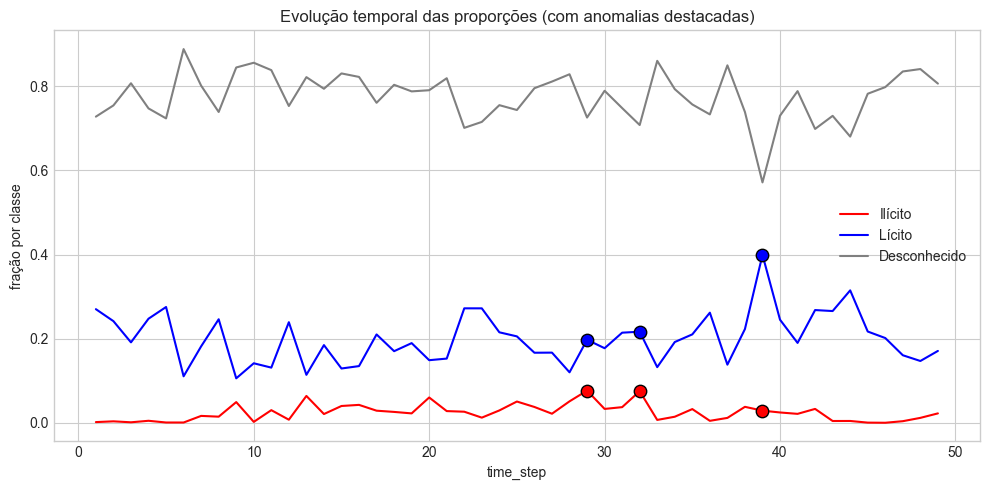

In [4]:
# ==========================================================
# Temporal evolution of class fractions
# ==========================================================
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(pivot["time_step"], pivot["frac_illicit"], label="Ilícito", color="red")
ax.plot(pivot["time_step"], pivot["frac_licit"], label="Lícito", color="blue")
ax.plot(pivot["time_step"], pivot["frac_unknown"], label="Desconhecido", color="gray")

# Highlight outliers
outliers = pivot[pivot["anom_score"] > 2]
ax.scatter(outliers["time_step"], outliers["frac_illicit"], color="red", s=80, edgecolor="k", zorder=3)
ax.scatter(outliers["time_step"], outliers["frac_licit"], color="blue", s=80, edgecolor="k", zorder=3)

ax.set_xlabel("time_step")
ax.set_ylabel("fração por classe")
ax.set_title("Evolução temporal das proporções (com anomalias destacadas)")
ax.legend()
plt.tight_layout()
plt.show()


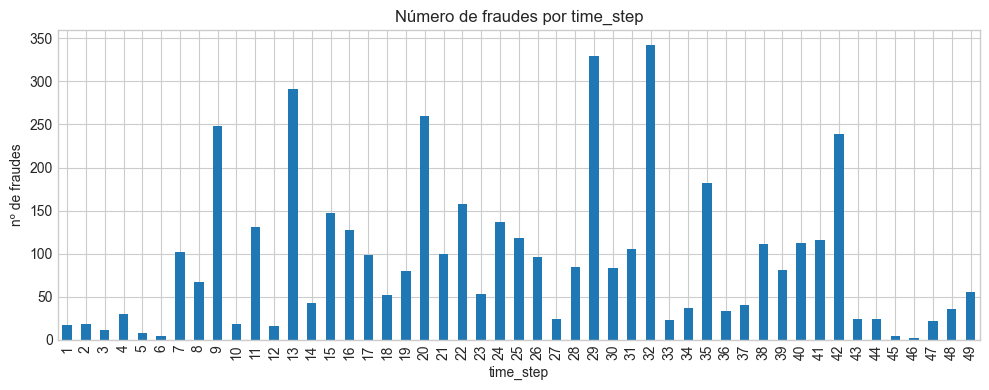

In [5]:
# ==========================================================
# Number of frauds per time_step
# ==========================================================
df_agg[df_agg["class"] == 1].plot(
    x="time_step",
    y="vol",
    kind="bar",
    figsize=(10,4),
    legend=False,
    title="Número de fraudes por time_step"
)
plt.xlabel("time_step")
plt.ylabel("nº de fraudes")
plt.tight_layout()
plt.show()


In [6]:
# ==========================================================
# Interactive visualization of class proportions (Plotly)
# ==========================================================

fig = go.Figure()

# Add traces for each class
fig.add_trace(go.Scatter(
    x=pivot["time_step"],
    y=pivot["frac_illicit"],
    mode="lines+markers",
    name="Ilícito",
    line=dict(color="red"),
))
fig.add_trace(go.Scatter(
    x=pivot["time_step"],
    y=pivot["frac_licit"],
    mode="lines+markers",
    name="Lícito",
    line=dict(color="blue"),
))
fig.add_trace(go.Scatter(
    x=pivot["time_step"],
    y=pivot["frac_unknown"],
    mode="lines+markers",
    name="Desconhecido",
    line=dict(color="gray"),
))

# Highlight anomalous points
anomalous_steps = pivot[pivot["anom_score"] > 2]
fig.add_trace(go.Scatter(
    x=anomalous_steps["time_step"],
    y=anomalous_steps["frac_illicit"],
    mode="markers",
    name="Anomalias (Ilícito)",
    marker=dict(color="red", size=10, symbol="circle", line=dict(color="black", width=1))
))
fig.add_trace(go.Scatter(
    x=anomalous_steps["time_step"],
    y=anomalous_steps["frac_licit"],
    mode="markers",
    name="Anomalias (Lícito)",
    marker=dict(color="blue", size=10, symbol="circle", line=dict(color="black", width=1))
))

# Customize layout
fig.update_layout(
    title="Evolução temporal das proporções por classe (interativo)",
    xaxis_title="time_step",
    yaxis_title="Fração por classe",
    hovermode="x unified",
    template="plotly_white",
    legend=dict(title="Classe", orientation="h", y=-0.2),
    height=500,
)

fig.show()


In [7]:
# ==========================================================
# Interactive bar chart: Number of frauds per time_step
# ==========================================================
df_illicit = df_agg[df_agg["class"] == 1]

fig = px.bar(
    df_illicit,
    x="time_step",
    y="vol",
    title="Número de fraudes por time_step (interativo)",
    labels={"vol": "nº de fraudes", "time_step": "time_step"},
    color="vol",
    color_continuous_scale="Reds",
)

fig.update_layout(
    template="plotly_white",
    height=400,
    xaxis=dict(showgrid=False),
    yaxis=dict(showgrid=True),
)
fig.show()
